# Superstore Sales Forecasting Notebook

##Purpose
This notebook is designed to **answer 7 forecasting questions** related to the *Superstore Sales* dataset.  
We will explore sales trends, seasonality, categories, sub-categories, regions, customer segments, and shipping modes.  
Each question is answered with **data visualizations** and **forecasting models** built using `pandas`, `scikit-learn`, and `matplotlib`.

---

## The 7 Forecasting Questions
1. **Future Sales Trend Over Time**  
   - How will total sales evolve month by month over the next 12–18 months?

2. **Seasonality & Peak Sales Periods**  
   - What seasonal patterns can we expect in sales, and which months/quarters will likely bring the highest sales?

3. **Category-Level Sales Forecast**  
   - How will sales differ across the three main categories (Furniture, Office Supplies, Technology) in the future?

4. **Sub-Category Performance Forecast**  
   - Which sub-categories (e.g., Chairs, Phones, Binders) are expected to grow or decline in sales?

5. **Regional Sales Forecast**  
   - How will sales be distributed across U.S. regions (West, East, Central, South) in the coming quarters?

6. **Customer Segment Forecast**  
   - Which customer segments (Consumer, Corporate, Home Office) will show the strongest sales growth in the future?

7. **Impact of Shipping Modes**  
   - How might shipping modes (Standard, Second Class, First Class, Same Day) influence sales volumes in the future?

---

## ⚙️ How We Answered Them
- We **aggregated sales monthly** and created forecasting features.  
- Applied **Ridge regression with Fourier terms** to capture seasonality and trend.  
- Visualized actual vs. fitted values and extended **forecasts into the future**.  
- Produced **comparative tables** to summarize expected sales across categories, regions, and segments.  

---

## Dataset Requirement
To run this notebook, please **download the cleaned dataset** first:  
[superstore_sales_cleaned.csv](https://github.com/Yousefabudaif/Superstore-Sales-Analysis-DEPI-round-3/blob/main/Week1/superstore_sales_cleaned.csv)  

After downloading, upload it into Colab (or adjust the path in the code).

---


In [3]:
# --- Setup & Load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Path: update if needed (e.g., to your Colab upload path)
CSV_PATH = "/content/superstore_sales_cleaned.csv"  # change if needed

df = pd.read_csv(CSV_PATH)
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Ship_Date']  = pd.to_datetime(df['Ship_Date'])

# Keep only needed columns
cols = ['Order_Date','Ship_Date','Region','Category','Sub_Category','Segment','Ship_Mode','Sales']
df = df[cols].copy()

# ensure nonnegative sales and drop weird rows if any
df = df[df['Sales'].ge(0)].copy()

df.head()

,Order_Date,Ship_Date,Region,Category,Sub_Category,Segment,Ship_Mode,Sales
0,2017-11-08,2017-11-11,South,Furniture,Bookcases,Consumer,Second Class,261.9600
1,2017-11-08,2017-11-11,South,Furniture,Chairs,Consumer,Second Class,731.9400
2,2017-06-12,2017-06-16,West,Office Supplies,Labels,Corporate,Second Class,14.6200
3,2016-10-11,2016-10-18,South,Furniture,Tables,Consumer,Standard Class,957.5775
4,2016-10-11,2016-10-18,South,Office Supplies,Storage,Consumer,Standard Class,22.3680


In [4]:
# helpers: monthly aggregation, Fourier features, ridge forecast, plotting

def prepare_monthly(series_df, date_col='Order_Date', value_col='Sales'):
    s = (series_df
         .set_index(date_col)
         .resample('MS')[value_col]
         .sum()
         .asfreq('MS')
         .fillna(0.0))
    return s

def make_features(n, offset=0, K=2, period=12):
    t = np.arange(offset, offset + n, dtype=float)
    feats = [t, t**2]
    for k in range(1, K+1):
        w = 2*np.pi*k/period
        feats += [np.sin(w*t), np.cos(w*t)]
    return np.column_stack(feats)

def ridge_forecast(y, horizon=12, test_size=6, alpha=1.0, K=2, period=12):
    n = len(y)
    X_all = make_features(n, offset=0, K=K, period=period)
    X_tr, X_te = X_all[:n-test_size], X_all[n-test_size:]
    y_tr, y_te = y[:n-test_size], y[n-test_size:]

    model = Ridge(alpha=alpha).fit(X_tr, y_tr)
    y_te_pred = model.predict(X_te)
    mae  = mean_absolute_error(y_te, y_te_pred)
    mape = mean_absolute_percentage_error(y_te, y_te_pred)

    final = Ridge(alpha=alpha).fit(X_all, y)
    X_future = make_features(horizon, offset=n, K=K, period=period)
    y_future = final.predict(X_future)
    y_fit = final.predict(X_all)

    return {'model': final,'y_fit': y_fit,'y_future': y_future,'mae': mae,'mape': mape}

def plot_history_forecast(idx, y, y_fit, future_values, title, ylabel="Sales", legend_loc='upper left'):
    plt.figure(figsize=(10,4.5))
    plt.plot(idx, y, linewidth=2, label='Actual')
    plt.plot(idx, y_fit, linestyle='--', linewidth=2, label='Fitted')
    future_idx = pd.date_range(idx[-1] + pd.offsets.MonthBegin(1), periods=len(future_values), freq='MS')
    plt.plot(future_idx, future_values, linewidth=2, label='Forecast')
    plt.title(title); plt.ylabel(ylabel); plt.xlabel('Month')
    plt.legend(loc=legend_loc); plt.grid(True); plt.tight_layout()
    return future_idx

Holdout MAE:  13713.92
Holdout MAPE: 15.12%
Forecasted overall trend over next 12 months: upward (60.2%).


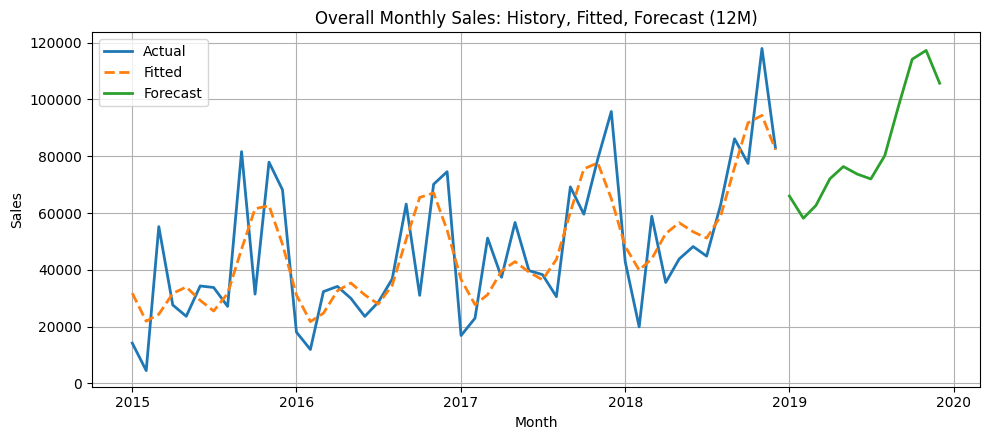

In [6]:
# q1: Overall monthly sales forecast (next 12 months)
s_all = prepare_monthly(df)
res = ridge_forecast(s_all.values, horizon=12, test_size=6, alpha=2.0, K=2, period=12)

future_idx = plot_history_forecast(s_all.index, s_all.values, res['y_fit'], res['y_future'],
                                   title='Overall Monthly Sales: History, Fitted, Forecast (12M)')

print(f"Holdout MAE:  {res['mae']:.2f}")
print(f"Holdout MAPE: {100*res['mape']:.2f}%")

trend = (res['y_future'][-1] - res['y_future'][0]) / max(res['y_future'][0], 1e-9)
direction = "upward" if trend > 0 else ("downward" if trend < 0 else "flat")
print(f"Forecasted overall trend over next 12 months: {direction} ({trend*100:.1f}%).")

Highest average month: 11


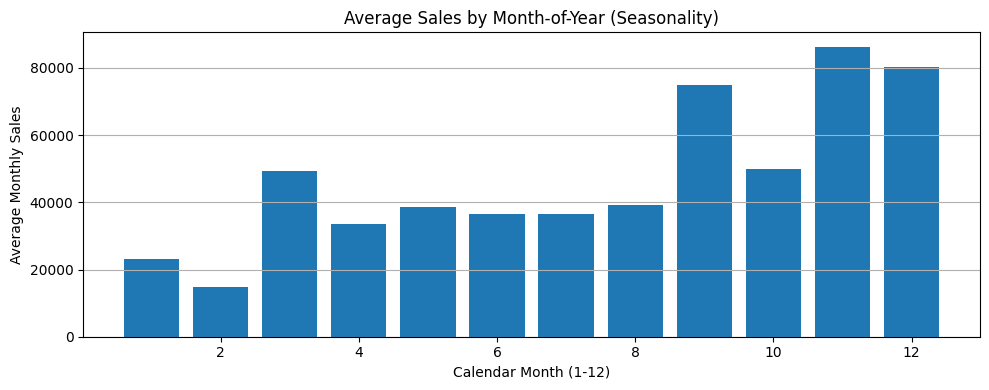

In [7]:
# Q2: Seasonality by month-of-year (averaged across years)
s_all = prepare_monthly(df)
seasonal = s_all.groupby(s_all.index.month).mean()

plt.figure(figsize=(10,4))
plt.bar(seasonal.index, seasonal.values)
plt.title('Average Sales by Month-of-Year (Seasonality)')
plt.xlabel('Calendar Month (1-12)')
plt.ylabel('Average Monthly Sales')
plt.grid(True, axis='y'); plt.tight_layout()

print(f"Highest average month: {int(seasonal.idxmax())}")

,Category,Next_6M_Sales_Forecast
2,Technology,153395.498457
1,Office Supplies,141984.798140
0,Furniture,113527.292009


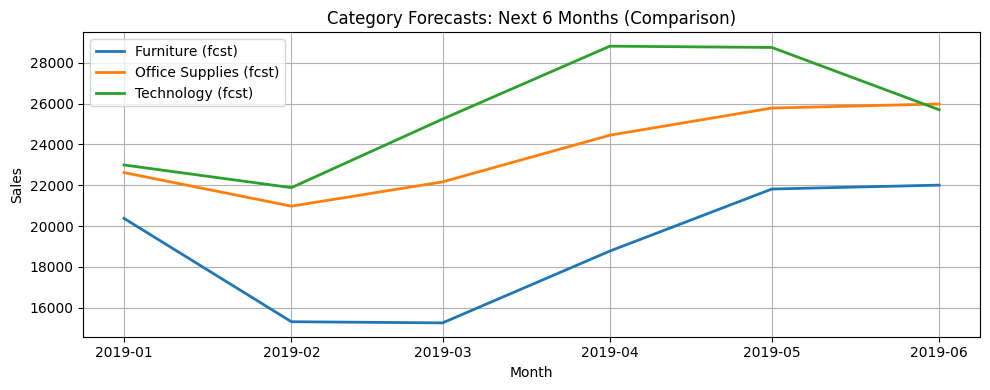

In [8]:
# --- Q3: Category-level forecasts (next 6 months)
cats = sorted(df['Category'].dropna().unique())
cat_future_summaries = []

plt.figure(figsize=(10,4))
for cat in cats:
    s_cat = prepare_monthly(df[df['Category'] == cat])
    res_c = ridge_forecast(s_cat.values, horizon=6, test_size=6, alpha=2.0, K=2, period=12)
    future_idx = pd.date_range(s_cat.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')
    plt.plot(future_idx, res_c['y_future'], linewidth=2, label=f'{cat} (fcst)')
    cat_future_summaries.append((cat, float(np.sum(res_c['y_future']))))

plt.title('Category Forecasts: Next 6 Months (Comparison)')
plt.xlabel('Month'); plt.ylabel('Sales')
plt.legend(); plt.grid(True); plt.tight_layout()

pd.DataFrame(cat_future_summaries, columns=['Category','Next_6M_Sales_Forecast']).sort_values('Next_6M_Sales_Forecast', ascending=False)

,Sub_Category,Next_6M_Sales_Forecast
0,Phones,56915.930282
1,Chairs,49944.639697
4,Binders,43794.000473
3,Tables,40659.548564
2,Storage,38195.469211
5,Machines,34612.091906


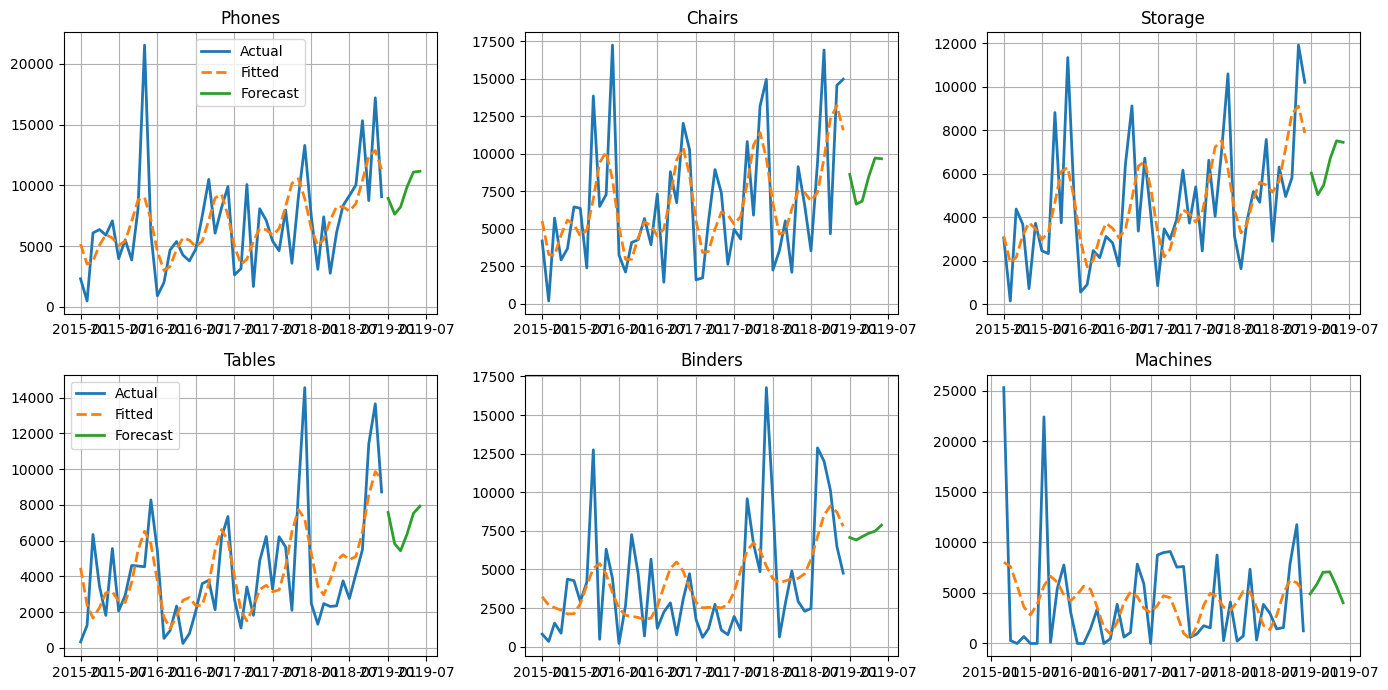

In [12]:
# --- Q4: Forecast top 6 sub-categories by historical sales, next 6 months
top_subs = (df.groupby('Sub_Category')['Sales'].sum().sort_values(ascending=False).head(6).index.tolist())

plt.figure(figsize=(14,7))
sub_summary = []
for i, sub in enumerate(top_subs, start=1):
    s_sub = prepare_monthly(df[df['Sub_Category'] == sub])
    res_s = ridge_forecast(s_sub.values, horizon=6, test_size=6, alpha=3.0, K=2, period=12)
    plt.subplot(2,3,i)
    plt.plot(s_sub.index, s_sub.values, linewidth=2, label='Actual')
    plt.plot(s_sub.index, res_s['y_fit'], linestyle='--', linewidth=2, label='Fitted')
    future_idx = pd.date_range(s_sub.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')
    plt.plot(future_idx, res_s['y_future'], linewidth=2, label='Forecast')
    plt.title(sub); plt.grid(True)
    if i in (1,4): plt.legend()
    sub_summary.append((sub, float(np.sum(res_s['y_future']))))

plt.tight_layout()
pd.DataFrame(sub_summary, columns=['Sub_Category','Next_6M_Sales_Forecast']).sort_values('Next_6M_Sales_Forecast', ascending=False)

,Region,Next_6M_Sales_Forecast
3,West,147455.030147
2,South,102773.227717
1,East,100389.645038
0,Central,58289.685704


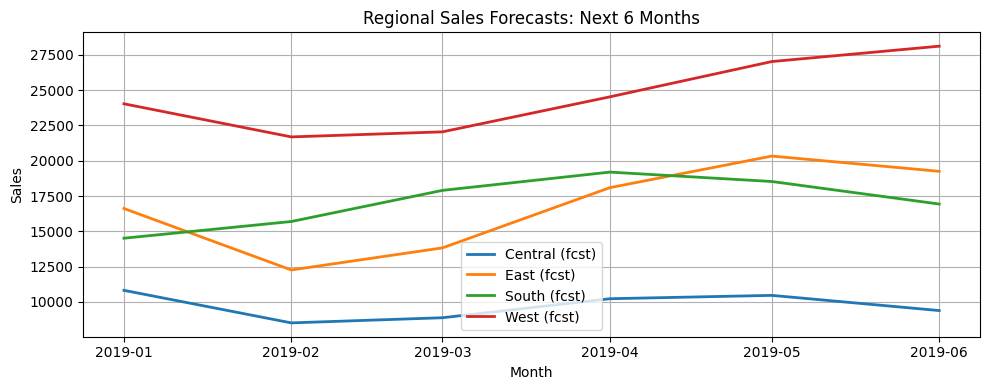

In [13]:
# --- Q5: Regional forecasts (next 6 months)
regions = sorted(df['Region'].dropna().unique())

plt.figure(figsize=(10,4))
reg_summary = []
for r in regions:
    s_r = prepare_monthly(df[df['Region'] == r])
    res_r = ridge_forecast(s_r.values, horizon=6, test_size=6, alpha=2.0, K=2, period=12)
    future_idx = pd.date_range(s_r.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')
    plt.plot(future_idx, res_r['y_future'], linewidth=2, label=f'{r} (fcst)')
    reg_summary.append((r, float(np.sum(res_r['y_future']))))

plt.title('Regional Sales Forecasts: Next 6 Months')
plt.xlabel('Month'); plt.ylabel('Sales')
plt.legend(); plt.grid(True); plt.tight_layout()
pd.DataFrame(reg_summary, columns=['Region','Next_6M_Sales_Forecast']).sort_values('Next_6M_Sales_Forecast', ascending=False)

,Segment,Next_6M_Sales_Forecast
0,Consumer,152578.535576
1,Corporate,142703.337231
2,Home Office,113625.715798


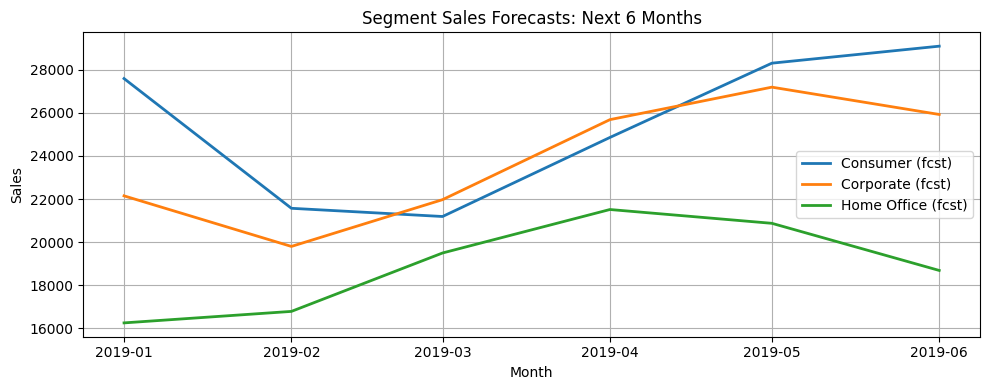

In [14]:
# --- Q6: Segment forecasts (next 6 months)
segments = sorted(df['Segment'].dropna().unique())

plt.figure(figsize=(10,4))
seg_summary = []
for seg in segments:
    s_g = prepare_monthly(df[df['Segment'] == seg])
    res_g = ridge_forecast(s_g.values, horizon=6, test_size=6, alpha=2.0, K=2, period=12)
    future_idx = pd.date_range(s_g.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')
    plt.plot(future_idx, res_g['y_future'], linewidth=2, label=f'{seg} (fcst)')
    seg_summary.append((seg, float(np.sum(res_g['y_future']))))

plt.title('Segment Sales Forecasts: Next 6 Months')
plt.xlabel('Month'); plt.ylabel('Sales')
plt.legend(); plt.grid(True); plt.tight_layout()
pd.DataFrame(seg_summary, columns=['Segment','Next_6M_Sales_Forecast']).sort_values('Next_6M_Sales_Forecast', ascending=False)

,Ship_Mode,Next_6M_Sales_Forecast
3,Standard Class,219254.699994
0,First Class,84776.614498
2,Second Class,75120.272785
1,Same Day,30351.408310


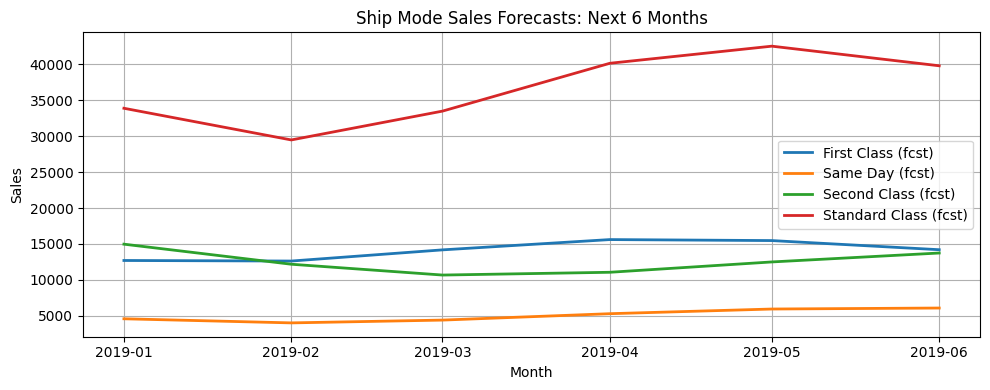

In [15]:
# --- Q7: Ship mode sales forecasts (next 6 months)
modes = sorted(df['Ship_Mode'].dropna().unique())

plt.figure(figsize=(10,4))
mode_summary = []
for m in modes:
    s_m = prepare_monthly(df[df['Ship_Mode'] == m])
    res_m = ridge_forecast(s_m.values, horizon=6, test_size=6, alpha=2.0, K=2, period=12)
    future_idx = pd.date_range(s_m.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')
    plt.plot(future_idx, res_m['y_future'], linewidth=2, label=f'{m} (fcst)')
    mode_summary.append((m, float(np.sum(res_m['y_future']))))

plt.title('Ship Mode Sales Forecasts: Next 6 Months')
plt.xlabel('Month'); plt.ylabel('Sales')
plt.legend(); plt.grid(True); plt.tight_layout()
pd.DataFrame(mode_summary, columns=['Ship_Mode','Next_6M_Sales_Forecast']).sort_values('Next_6M_Sales_Forecast', ascending=False)